begin  2007-01-01 00:00:00
Data for stock: sz.000022 not found.
begin  2007-02-01 00:00:00
Data for stock: sz.000022 not found.
begin  2007-03-01 00:00:00
Data for stock: sz.000022 not found.
begin  2007-04-01 00:00:00
Data for stock: sz.000022 not found.
begin  2007-05-01 00:00:00
Data for stock: sz.000022 not found.
begin  2007-06-01 00:00:00
Data for stock: sz.000022 not found.
begin  2007-07-01 00:00:00
begin  2007-08-01 00:00:00
begin  2007-09-01 00:00:00
begin  2007-10-01 00:00:00
begin  2007-11-01 00:00:00
begin  2007-12-01 00:00:00
begin  2008-01-01 00:00:00
begin  2008-02-01 00:00:00
begin  2008-03-01 00:00:00
begin  2008-04-01 00:00:00
begin  2008-05-01 00:00:00
begin  2008-06-01 00:00:00
begin  2008-07-01 00:00:00
begin  2008-08-01 00:00:00
begin  2008-09-01 00:00:00
begin  2008-10-01 00:00:00
begin  2008-11-01 00:00:00
begin  2008-12-01 00:00:00
begin  2009-01-01 00:00:00
begin  2009-02-01 00:00:00
begin  2009-03-01 00:00:00
begin  2009-04-01 00:00:00
begin  2009-05-01 00:0

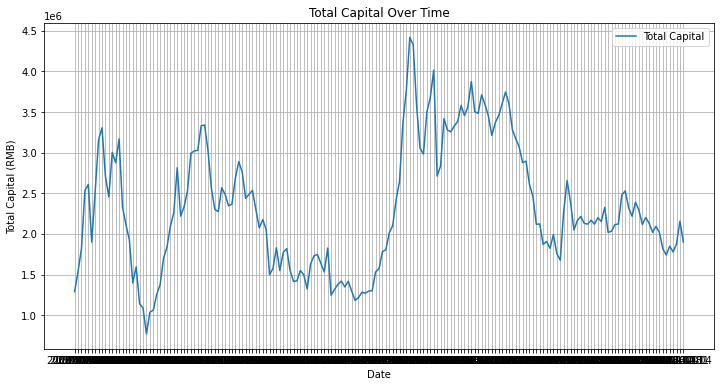

In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 定义目录路径
amount_directory = 'stock_amount'
market_value_directory = 'stock_market_value'
hs300_directory = 'hs300_stocks'


# 定义缓存字典
amount_cache = {}

# 读取股票历史上某月头尾交易日的成交金额数据
def read_stock_data(stock_code, month):
    amount_file_path = os.path.join(amount_directory, f'{stock_code}_amount.csv')
    
    if stock_code in amount_cache:
        amount_df = amount_cache[stock_code]
    else:
        if os.path.exists(amount_file_path):
            amount_df = pd.read_csv(amount_file_path)
            amount_df['日期'] = pd.to_datetime(amount_df['日期'])
            amount_df.set_index('日期', inplace=True)
            amount_cache[stock_code] = amount_df
        else:
            print(f'Data for stock: {stock_code} not found.')
            return 0, 0
    # 获取该月份的第一个交易日和最后一个交易日
    monthly_trade_dates = amount_df[amount_df.index.to_period('M') == month.to_period('M')]
    if not monthly_trade_dates.empty:
        first_trade_day = monthly_trade_dates.index[0]
        last_trade_day = monthly_trade_dates.index[-1]
        open_price = monthly_trade_dates.loc[first_trade_day, '开盘']
        close_price = monthly_trade_dates.loc[last_trade_day, '收盘']
        return open_price, close_price
    return 0, 0

    
market_value_cache = {}
def get_top_10_lowest_market_value_stocks(stock_codes, date):
    market_values = []
    
    for stock_code in stock_codes:
        open_price, close_price = read_stock_data(stock_code, pd.to_datetime(date))
        if open_price < 2:
            continue
            
            
        if stock_code in market_value_cache:
            market_value_df = market_value_cache[stock_code]
        else:
            market_value_file_path = os.path.join(market_value_directory, f'{stock_code}_market_value.csv')
            if os.path.exists(market_value_file_path):
                market_value_df = pd.read_csv(market_value_file_path)
                market_value_df['trade_date'] = pd.to_datetime(market_value_df['trade_date'])
                market_value_df.set_index('trade_date', inplace=True)
                market_value_cache[stock_code] = market_value_df

        if date in market_value_df.index:
            market_value = market_value_df.loc[date, 'total_mv']
            market_values.append((stock_code, market_value))
    
    # 按总市值排序并取前10只股票
    market_values.sort(key=lambda x: x[1])
    top_10_stocks = [stock[0] for stock in market_values[:10]]
    
    return top_10_stocks

# 获取某个月的沪深300成分股
def get_hs300_stocks(date):
    hs300_files = os.listdir(hs300_directory)
    target_month = date.strftime("%Y-%m")
    
    for file_name in hs300_files:
        if target_month in file_name:
            hs300_file_path = os.path.join(hs300_directory, file_name)
            df = pd.read_csv(hs300_file_path)
            file_date = file_name.split('_')[2].split('.')[0]  # 提取文件名中的日期部分
            return df['stock_code'].tolist(), file_date
            # return ['sz.300750'], file_date
    
    print(f'HS300 data for {target_month} not found.')
    return [], None


# 初始资金
initial_capital = 1000000

# 模拟交易策略
def simulate_strategy(initial_capital, start_date, end_date):
    monthly_capital = []
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    
    while current_date <= end_date:
        print("begin ", current_date)
        capital = 0
        hs300_stocks, first_date = get_hs300_stocks(current_date)
        
        if not hs300_stocks:
            current_date += pd.DateOffset(months=1)
            continue
        last10_stocks = get_top_10_lowest_market_value_stocks(hs300_stocks, first_date)
        
        # 购买股票
        stock_positions = {}
        for stock in last10_stocks:
            open_price, close_price = read_stock_data(stock, pd.to_datetime(first_date))
            stock_num = initial_capital / len(last10_stocks) / open_price
            capital += stock_num * close_price
            # print(first_date, initial_capital, open_price, stock_num, capital, close_price)
        
        monthly_capital.append((first_date, capital, last10_stocks))
        current_date += pd.DateOffset(months=1)
        initial_capital = capital
    
    return monthly_capital

monthly_capital = simulate_strategy(initial_capital, '2007-01-01', '2022-01-31')

capital_df = pd.DataFrame(monthly_capital, columns=['Date', 'Capital', 'Stocks'])
capital_df.set_index('Date', inplace=True)

print(capital_df)
capital_df.to_csv("./xiaopan.csv", encoding="utf8", index=False)


# 绘制资产曲线
plt.figure(figsize=(12, 6))
plt.plot(capital_df.index, capital_df['Capital'], label='Total Capital')
plt.title('Total Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Total Capital (RMB)')
plt.legend()
plt.grid(True)
plt.show()